In [40]:
import re
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.2)

%matplotlib inline

In [41]:
def get_df(athlete_id: int):
    athlete_url = f'https://www.parkrun.ru/results/athleteeventresultshistory/?athleteNumber={athlete_id}&eventNumber=0'
    page_all_results = requests.get(athlete_url, headers={'User-Agent': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:86.0) Gecko/20100101 Firefox/86.0'})
    df = pd.read_html(page_all_results.text)[2]
    df['Год'] = pd.to_datetime(df['Дата parkrun'], dayfirst=True).dt.year
    df['Месяц'] = pd.to_datetime(df['Дата parkrun'], dayfirst=True).dt.month_name(locale='ru_RU.UTF-8').str.slice(stop=3)
    return df

In [42]:
# Personal parkrun ID
my_id = 875743

In [43]:
df = get_df(my_id)
df

,Паркран,Дата parkrun,Номер пробежки,Место,Время,Рейтинг,ЛР?,Год,Месяц
0,Kuzminki,01/05/2021,208,6,19:57,67.42%,NaN,2021,Мая
1,Kuzminki,24/04/2021,207,21,23:09,58.10%,NaN,2021,Апр
2,Tula Central,23/01/2021,178,2,20:00,67.25%,NaN,2021,Янв
3,Tula Central,16/01/2021,177,1,20:11,66.64%,NaN,2021,Янв
4,Tula Central,09/01/2021,176,2,19:52,67.70%,NaN,2021,Янв
...,...,...,...,...,...,...,...,...,...
181,Gorky Park,25/10/2014,25,1,18:07,71.76%,NaN,2014,Окт
182,Kolomenskoe,22/03/2014,4,2,19:14,67.42%,NaN,2014,Мар
183,Kolomenskoe,15/03/2014,3,10,20:01,64.78%,NaN,2014,Мар
184,Kolomenskoe,08/03/2014,2,2,18:59,68.31%,NaN,2014,Мар


In [44]:
months = ['Янв','Фев','Мар','Апр','Мая','Июн','Июл','Авг','Сен','Окт','Ноя','Дек']

In [45]:
rundata_long = df.pivot_table(index='Месяц', columns='Год', values='Время', aggfunc=len, fill_value=0).astype(int)

for month in months:
    if month not in rundata_long.index.values:
        rundata_long.loc[month] = 0
# sort chronological
rundata_long = rundata_long.reindex(months)
maxruns = rundata_long.max().max()

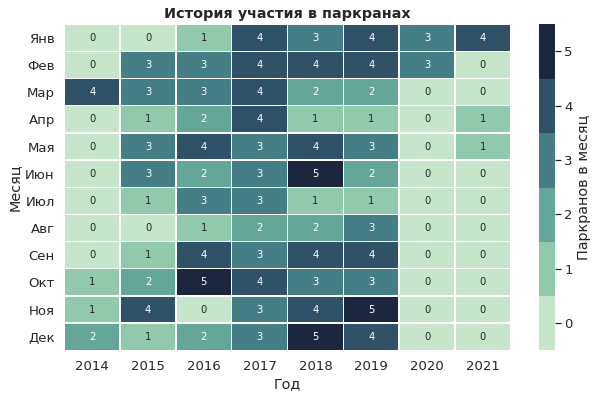

CPU times: user 2.96 s, sys: 3.03 s, total: 5.99 s
Wall time: 10.7 s


In [46]:
%%time
fig, ax = plt.subplots(figsize=(10, 6))

# Plot number of runs by month/year
cmap = sns.cubehelix_palette(rot=-.4, n_colors=maxruns+1)

ticks=np.arange(0,maxruns+1)
boundaries = np.arange(-0.5,maxruns+1.5 )

ax = sns.heatmap(rundata_long, annot=True, linewidths=0.4, cmap=cmap,
                 cbar_kws={"ticks":ticks, "boundaries":boundaries, 'label': 'Паркранов в месяц'})
ax.set_title("История участия в паркранах", fontweight='bold')

plt.show()

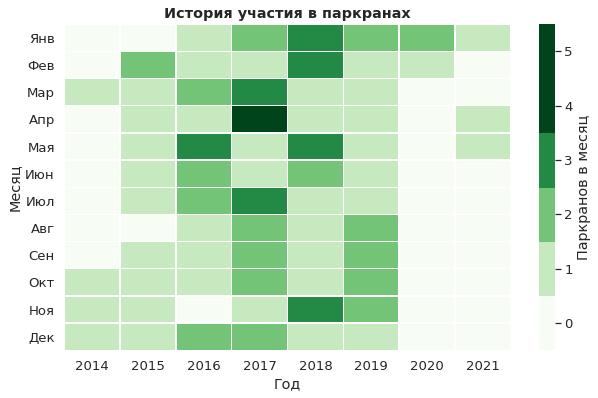

CPU times: user 802 ms, sys: 507 ms, total: 1.31 s
Wall time: 2 s


In [89]:
%%time
fig, ax = plt.subplots(figsize=(10, 6))

ticks=np.arange(0, maxruns+1)
boundaries = np.arange(-0.5, maxruns+1.5)

sns.heatmap(rundata_long, linewidths=0.4, cmap='Greens',
            cbar_kws={"ticks":ticks, "boundaries":boundaries, 'label': 'Паркранов в месяц'})
ax.set_title("История участия в паркранах", fontweight='bold')

plt.show()

In [48]:
# Extract times in minutes
df['t_m']=df['Время'].transform(lambda time: sum(x * int(t) for x, t in zip([1/60, 1, 60], time.split(':')[::-1])))

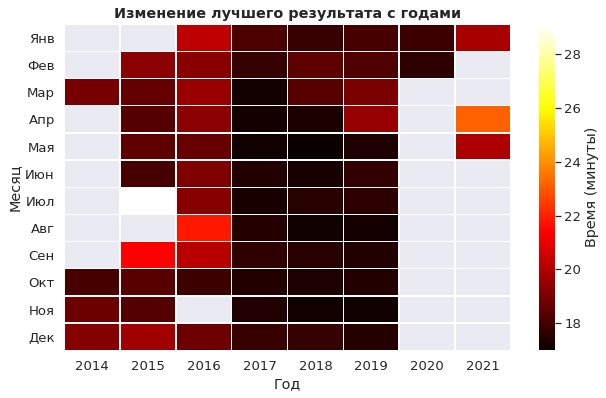

CPU times: user 865 ms, sys: 486 ms, total: 1.35 s
Wall time: 1.94 s


In [91]:
%%time
fig, ax = plt.subplots(figsize=(10, 6))

# pivot df into long form and aggregate by fastest time
rundata_long = df.pivot_table(index='Месяц', columns='Год', values='t_m', aggfunc=np.min, fill_value=np.nan)
# add rows of zeros for any months missed
for month in months:
    if month not in rundata_long.index.values :
        rundata_long.loc[month] = np.nan
# sort chronological
rundata_long = rundata_long.reindex(months)

sns.heatmap(rundata_long, linewidths=0.4, cmap='hot', cbar_kws={'label': 'Время (минуты)'}, ax=ax)
ax.set_title("Изменение лучшего результата с годами", fontweight='bold')
plt.show()

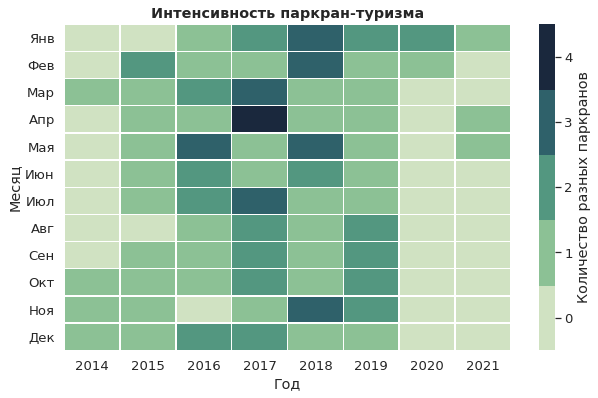

CPU times: user 887 ms, sys: 452 ms, total: 1.34 s
Wall time: 1.87 s


In [92]:
%%time
fig, ax = plt.subplots(figsize=(10, 6))
aggfun = lambda parkruns: len(np.unique(parkruns, return_counts = True)[1])
# pivot df into long form and aggregate by fastest time
rundata_long = df.pivot_table(index='Месяц', columns='Год', values='Паркран', aggfunc=aggfun, fill_value=0)
maxuniq = rundata_long.max().max()

# add rows of zeros for any months missed
for month in months:
    if month not in rundata_long.index.values :
        rundata_long.loc[month] = np.nan
# sort chronological
rundata_long = rundata_long.reindex(months)
cmap = sns.cubehelix_palette(rot=-.5, n_colors=maxuniq+1)

ticks=np.arange(0, maxuniq+1)
boundaries = np.arange(-0.5, maxuniq+1.5)

sns.heatmap(rundata_long, linewidths=0.4, cmap=cmap, cbar_kws={"ticks":ticks, 'label': 'Количество разных паркранов', "boundaries":boundaries}, ax=ax)
ax.set_title("Интенсивность паркран-туризма", fontweight='bold')
plt.show()

In [81]:
pd.to_datetime(df['Дата parkrun'], dayfirst=True).dt.year

0      2021
1      2021
2      2021
3      2021
4      2021
       ... 
181    2014
182    2014
183    2014
184    2014
185    2014
Name: Дата parkrun, Length: 186, dtype: int64

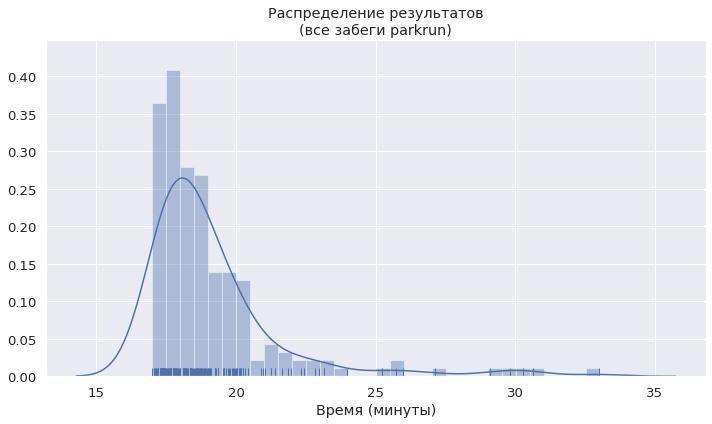

In [20]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.distplot(df['t_m'], bins=32, rug=True, ax=ax)
ax.set(ylabel='', xlabel='Время (минуты)', title='Распределение результатов\n(все забеги parkrun)')

# ax.invert_yaxis()
plt.tight_layout()

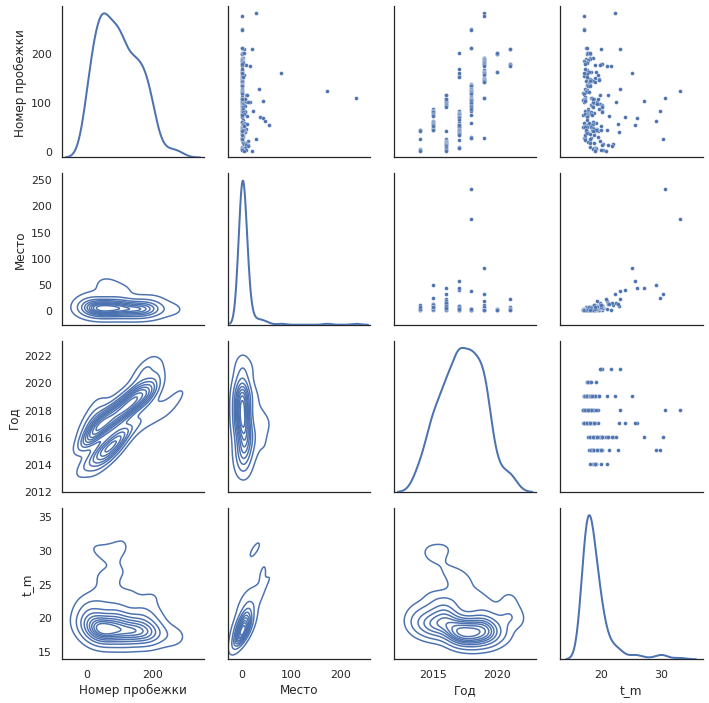

In [29]:
sns.set_theme(style="white")

g = sns.PairGrid(df, diag_sharey=False)
g.map_upper(sns.scatterplot, s=15)
g.map_lower(sns.kdeplot)
g.map_diag(sns.kdeplot, lw=2)

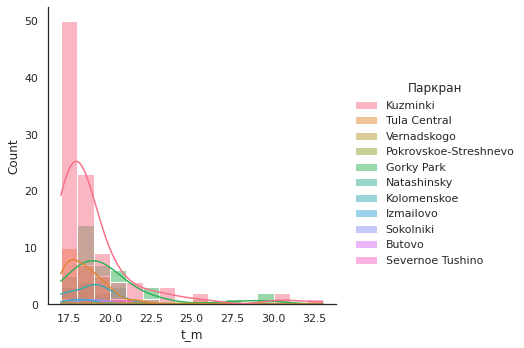

In [31]:
sns.displot(data=df, x='t_m', hue="Паркран", bins=16, kde=True)

<AxesSubplot:xlabel='t_m', ylabel='Паркран'>

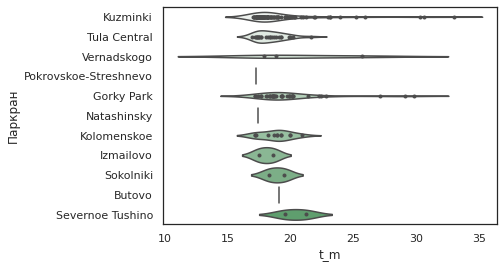

In [39]:
sns.violinplot(data=df, x='t_m', y='Паркран', palette="light:g", inner="points", orient="h")